**$$Delhivery \ Case \ Study$$**

Problem Statement:<br>
1. Clean and sanitize raw data from logistics operations.

2. Extract meaningful features that represent operational performance (e.g., trip duration, delays, route efficiency).

3. Prepare this data to enable the Data Science team to build robust forecasting models (e.g., ETA prediction, delay forecasting, capacity planning).

4. Support business decisions by generating insights that can highlight bottlenecks, inefficiencies, or opportunities.

In [236]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
!wget https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/551/original/delhivery_data.csv

--2025-06-05 07:07:28--  https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/551/original/delhivery_data.csv
Resolving d2beiqkhq929f0.cloudfront.net (d2beiqkhq929f0.cloudfront.net)... 13.224.9.103, 13.224.9.24, 13.224.9.129, ...
Connecting to d2beiqkhq929f0.cloudfront.net (d2beiqkhq929f0.cloudfront.net)|13.224.9.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55617130 (53M) [text/plain]
Saving to: ‘delhivery_data.csv’

delhivery_data.csv  100%[===================>]  53.04M   241MB/s    in 0.2s    

2025-06-05 07:07:28 (241 MB/s) - ‘delhivery_data.csv’ saved [55617130/55617130]



In [5]:
df = pd.read_csv('/content/delhivery_data.csv')

In [ ]:
df.head()

In [7]:
df.shape

(144867, 24)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   data                            144867 non-null  object 
 1   trip_creation_time              144867 non-null  object 
 2   route_schedule_uuid             144867 non-null  object 
 3   route_type                      144867 non-null  object 
 4   trip_uuid                       144867 non-null  object 
 5   source_center                   144867 non-null  object 
 6   source_name                     144574 non-null  object 
 7   destination_center              144867 non-null  object 
 8   destination_name                144606 non-null  object 
 9   od_start_time                   144867 non-null  object 
 10  od_end_time                     144867 non-null  object 
 11  start_scan_to_end_scan          144867 non-null  float64
 12  is_cutoff       

In [9]:
df.columns

Index(['data', 'trip_creation_time', 'route_schedule_uuid', 'route_type',
       'trip_uuid', 'source_center', 'source_name', 'destination_center',
       'destination_name', 'od_start_time', 'od_end_time',
       'start_scan_to_end_scan', 'is_cutoff', 'cutoff_factor',
       'cutoff_timestamp', 'actual_distance_to_destination', 'actual_time',
       'osrm_time', 'osrm_distance', 'factor', 'segment_actual_time',
       'segment_osrm_time', 'segment_osrm_distance', 'segment_factor'],
      dtype='object')

In [ ]:
df.describe()

In [11]:
df.isnull().sum()

,0
data,0
trip_creation_time,0
route_schedule_uuid,0
route_type,0
trip_uuid,0
source_center,0
source_name,293
destination_center,0
destination_name,261
od_start_time,0


**Converting object columns to Datetime**

In [12]:
datetime_col = ['trip_creation_time','od_start_time','od_end_time']
for col in datetime_col:
  df[col]= pd.to_datetime(df[col])


**Preliminary insights:**
1. we have 144867 rows and 24 columns
2. we have two columns **source_name** and **destination_name** with null values
3. trip_creation_time,od_start_time,od_end_time have object as dtypes and i have converted it to datetime dtype.

In [161]:
df['od_time_diff'] = (df['od_end_time'] - df['od_start_time']).dt.total_seconds()/60

In [ ]:
df['segment_key']= df['trip_uuid'] + df['source_center'] + df['destination_center']
segement_cols = ['segment_actual_time','segment_osrm_distance','segment_osrm_time','od_time_diff']
for col in segement_cols:
  df[col + '_sum'] = df.groupby('segment_key')[col].cumsum()

df[[col +'_sum' for col in segement_cols]]

In [18]:
create_segement_dict= {
    'data':'first',
    'trip_creation_time':'first',
    'trip_uuid': 'first',
    'route_type': 'first',

    'source_center':'last',
    'source_name':'last',

    'destination_center':'first',
    'destination_name': 'first',

    'od_start_time': 'first',
    'od_end_time':'first',
    'od_time_diff': 'last',
    'start_scan_to_end_scan':'first',

    'actual_distance_to_destination': 'last',
    'actual_time':'last',
    'osrm_time':'last',
    'osrm_distance':'last',

    'segment_actual_time_sum': 'last',
    'segment_osrm_distance_sum':'last',
    'segment_osrm_time_sum': 'last'
}

In [ ]:
segment = df.groupby('segment_key').agg(create_segement_dict).reset_index()
segment

In [21]:
create_trip_dict= {
    'data':'first',
    'trip_creation_time': 'first',
    'trip_uuid' :'first',
    'route_type':'first',

    'source_center': 'last',
    'source_name': 'last',

    'destination_center' : 'first',
    'destination_name': 'first',

    'od_time_diff': 'sum',
    'start_scan_to_end_scan':'sum',
    'actual_distance_to_destination': 'sum',
    'actual_time': 'sum',
    'osrm_time':'sum',
    'osrm_distance': 'sum',

    'segment_actual_time_sum': 'sum',
    'segment_osrm_time_sum': 'sum',
    'segment_osrm_distance_sum':'sum'

}

**Final Dataframe with trip level aggregration**

In [230]:
trip = segment.groupby('trip_uuid').agg(create_trip_dict).reset_index(drop=True)

**Feature Creation**

In [231]:

trip['factor_actual'] = trip['actual_time']/trip['osrm_time']
trip['factor_segment'] = trip['segment_actual_time_sum'] / trip['segment_osrm_time_sum']
trip['factor_actual_distance'] = trip['actual_distance_to_destination']/ trip['osrm_distance']
trip['actual_osrm_distance_diff']= trip['actual_distance_to_destination'] - trip['osrm_distance']
trip['actual_osrm_time_diff']= trip['actual_time'] - trip['osrm_time']

**Extracting states,cities,depots details from source name**

In [232]:
states =[]
cities =[]
depots = []

for col in trip['source_name']:
  if pd.notnull(col):
      try:
        name_part,state_part = col.split(' (')
        city,depot = name_part.split('_',1)
        state = state_part.replace(')', '')
        # print(state.dtype)
        states.append(state)
        cities.append(city)
        depots.append(depot)


      except ValueError:
        states.append(None)
        cities.append(None)
        depots.append(None)
  else:
      states.append(None)
      cities.append(None)
      depots.append(None)


trip['state'] = states
trip['city'] = cities
trip['depot'] = depots


**Extracting years,months,days information from trip creation time**

In [233]:
years=[]
months =[]
days =[]

for col in trip['trip_creation_time']:
  if pd.notnull(col):
    try:
        year = col.year
        month = col.strftime('%B')
        day = col.strftime('%A')

        years.append(year)
        months.append(month)
        days.append(day)
    except ValueError:
        years.append(None)
        months.append(None)
        days.appned(None)
  else:
      years.append(None)
      months.append(None)
      days.appned(None)


trip['year'] = years
trip['month'] = months
trip['day'] = days

**Droping rows with missing values**

In [180]:
trip = trip.dropna(subset=['source_name', 'destination_name'])
trip[['state', 'city', 'depot']] = trip[['state', 'city', 'depot']].fillna('None')


In [ ]:
trip[['actual_time','osrm_time','segment_actual_time_sum','segment_osrm_time_sum']]

In [181]:
trip.isnull().sum()

,0
data,0
trip_creation_time,0
trip_uuid,0
route_type,0
source_center,0
source_name,0
destination_center,0
destination_name,0
od_time_diff,0
start_scan_to_end_scan,0


**Basic EDA from the data**

**States with highest and lowest number of delivery trips**




In [ ]:
highest_delivery_states = trip.groupby('state')['trip_uuid'].count().sort_values(ascending=False).head(10).reset_index()
lowest_delivery_states = trip.groupby('state')['trip_uuid'].count().sort_values(ascending=True).head(10).reset_index()

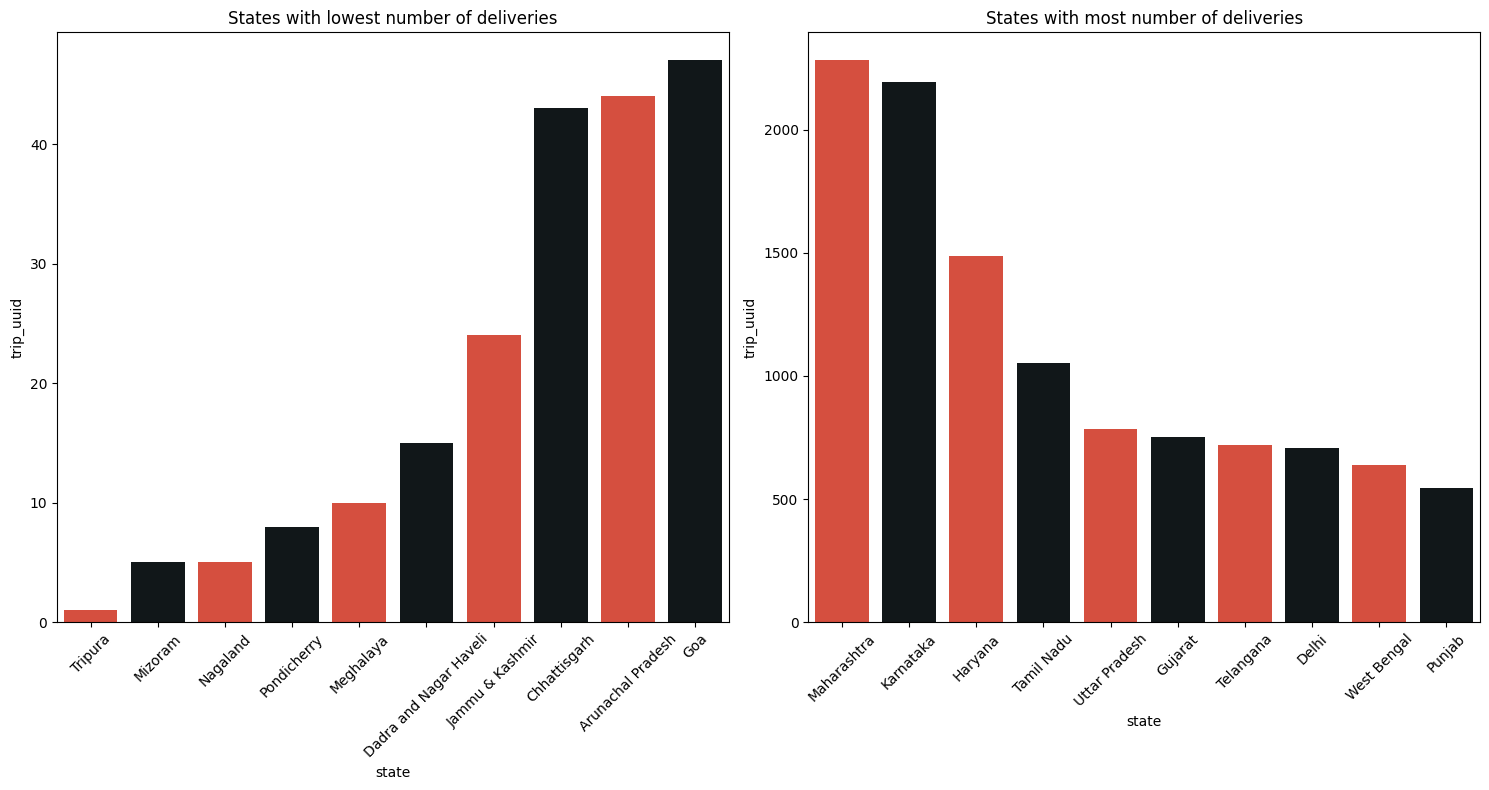

In [89]:
colors = ['#EE3C26', '#0F181B'] * (len(lowest_delivery_states) // 2 + 1)
colors = colors[:len(lowest_delivery_states)]  # Trim to match length
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
sns.barplot(data= lowest_delivery_states,x='state',y='trip_uuid',palette=colors)
plt.xticks(rotation= 45)
plt.title("States with lowest number of deliveries")

plt.subplot(1,2,2)
sns.barplot(data= highest_delivery_states,x='state',y='trip_uuid',palette=colors)
plt.xticks(rotation= 45)
plt.title("States with most number of deliveries")
plt.tight_layout()
plt.show()

**Carting Vs Full Truck Load**

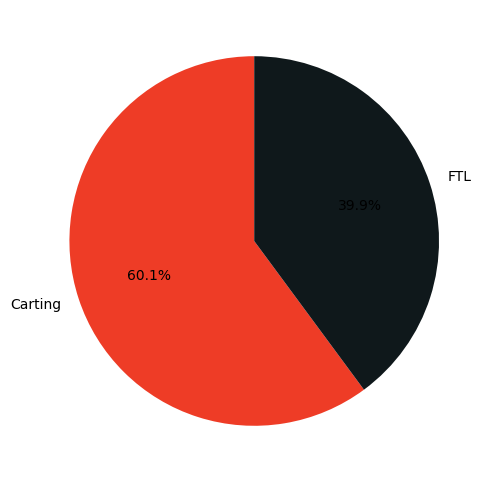

In [86]:
plt.figure(figsize=(6,6))
carting_ftl = trip.groupby('route_type')['trip_uuid'].count()
plt.pie(carting_ftl,labels= carting_ftl.index, autopct= '%1.1f%%',startangle=90,colors=['#EE3C26', '#0F181B'])
plt.show()

**Trips per month**

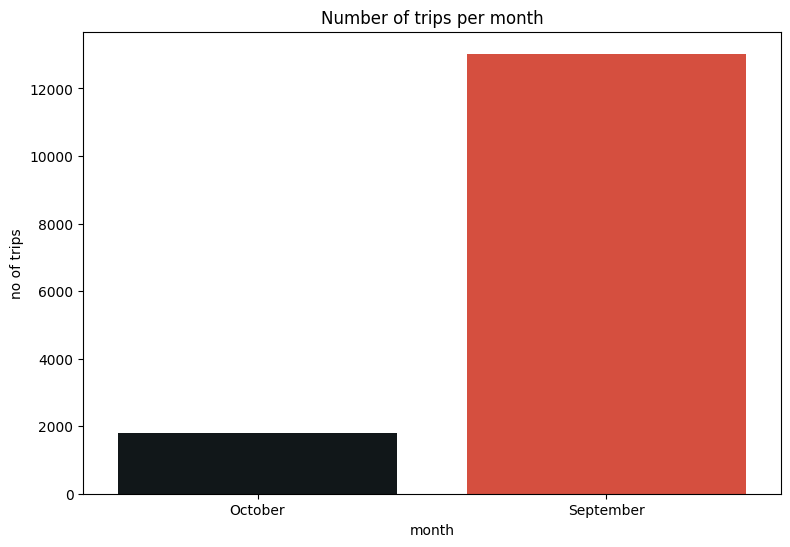

In [140]:
trip_per_month= trip.groupby('month')['trip_uuid'].count().reset_index().rename(columns={'trip_uuid':"no of trips"})
plt.figure(figsize=(9,6))
colors = ['#0F181B','#EE3C26'] * (len(lowest_delivery_states) // 2 + 1)
colors = colors[:len(lowest_delivery_states)]  # Trim to match length
sns.barplot(data= trip_per_month,x='month',y='no of trips',palette=colors)
plt.title('Number of trips per month')
plt.show()

**Trips per day of Week**

Text(0.5, 1.0, 'Number of trips per day of week')

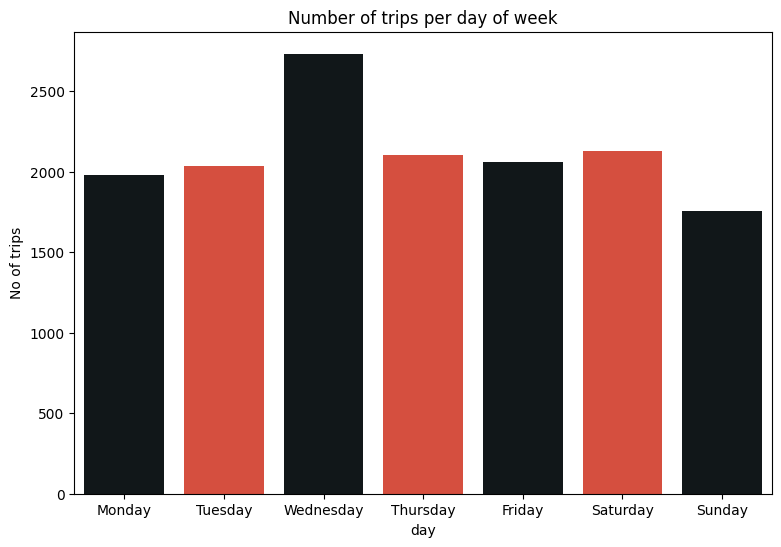

In [192]:
trip_per_day = trip.groupby('day')['trip_uuid'].count().reset_index().rename(columns={'trip_uuid':'No of trips'})
day_count= ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
trip_per_day['day'] = pd.Categorical(trip_per_day['day'],categories= day_count,ordered=True)
trip_per_day= trip_per_day.sort_values('day')
plt.figure(figsize=(9,6))
trip_per_day
sns.barplot(data= trip_per_day,x='day',y='No of trips',palette=colors)
plt.title('Number of trips per day of week')


In [ ]:
count_metrics= {
    'trip_uuid': 'count',
    'actual_osrm_time_diff':'mean',
    'actual_time':'mean',
    'actual_distance_to_destination':'mean'
}
routes_detail =trip.groupby(['source_center','destination_center','source_name','destination_name']).agg(count_metrics).rename(columns={'trip_uuid':'No. of trips','actual_time':'average_time','actual_osrm_time_diff':'average delay'}).reset_index()
routes_detail.sort_values(by ='average delay', ascending = False).head(10)

**Top 10 most busiest routes**

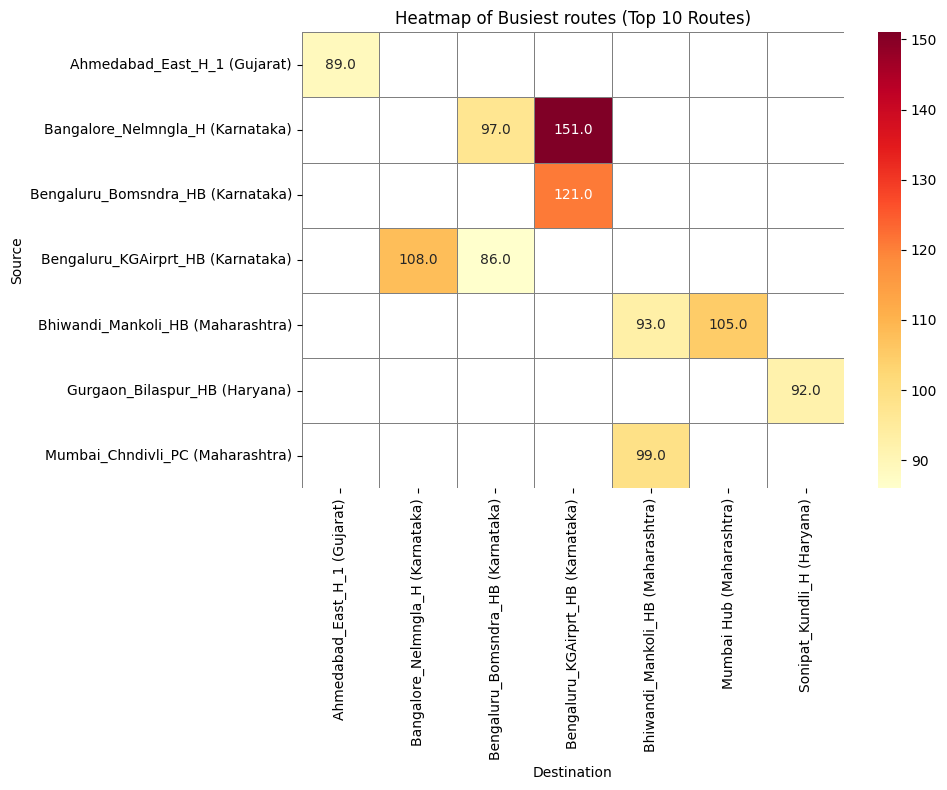

In [225]:
routes_detail.sort_values(by ='No. of trips', ascending = False).head(10)
plt.figure(figsize = (10,8))
busy_routes=pd.DataFrame()
# delay_routes= most_delayed_routes[['source_name','destination_name','average delay']].head(10)
busy_routes = pd.pivot_table(data= routes_detail.sort_values(by = 'No. of trips',ascending=False).head(10),
    index= 'source_name',
    columns= 'destination_name',
    values = 'No. of trips'
)
sns.heatmap(data= busy_routes,annot=True, fmt = '.1f',cmap="YlOrRd",linewidths=0.5, linecolor='gray')
plt.title("Heatmap of Busiest routes (Top 10 Routes)")
plt.xlabel("Destination")
plt.ylabel("Source")
plt.tight_layout()
plt.show()

**Top 10 route with most average delays**

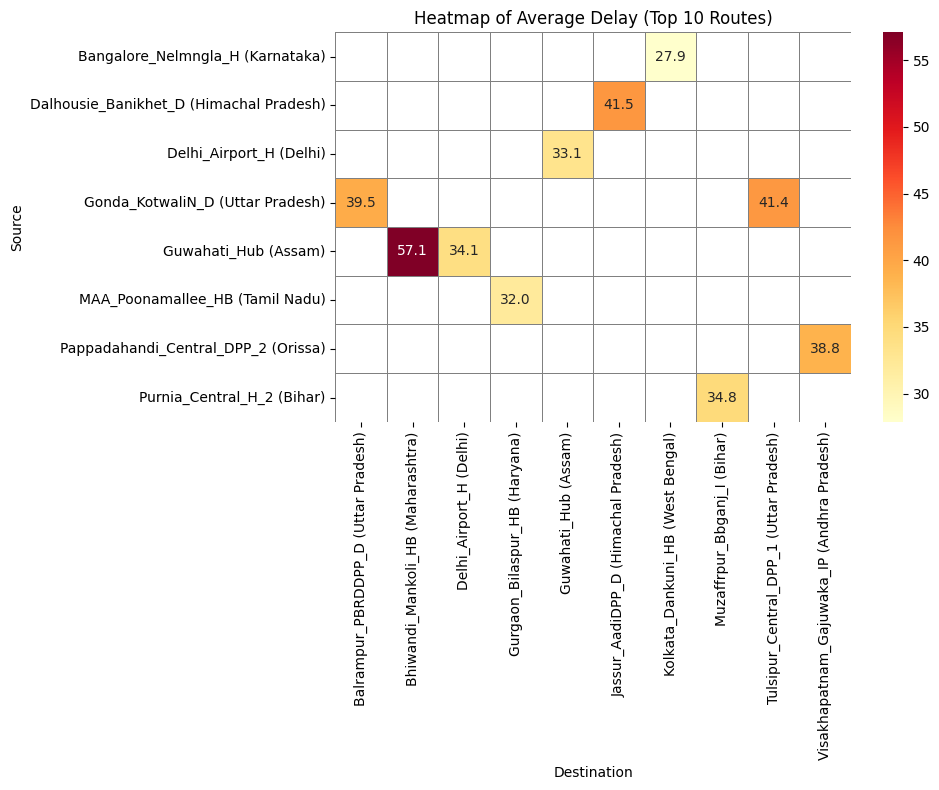

In [226]:
plt.figure(figsize = (10,8))
delay_routes=pd.DataFrame()
# delay_routes= most_delayed_routes[['source_name','destination_name','average delay']].head(10)
delay_routes = pd.pivot_table(data= routes_detail.sort_values(by = 'average delay',ascending=False).head(10),
    index= 'source_name',
    columns= 'destination_name',
    values = 'average delay'
)
sns.heatmap(data= delay_routes,annot=True, fmt = '.1f',cmap="YlOrRd",linewidths=0.5, linecolor='gray')
plt.title("Heatmap of Average Delay (Top 10 Routes)")
plt.xlabel("Destination")
plt.ylabel("Source")
plt.tight_layout()
plt.show()

**$$Comparision of Aggregrated Data$$**

**Comparision of Actual Time with OSRM time**

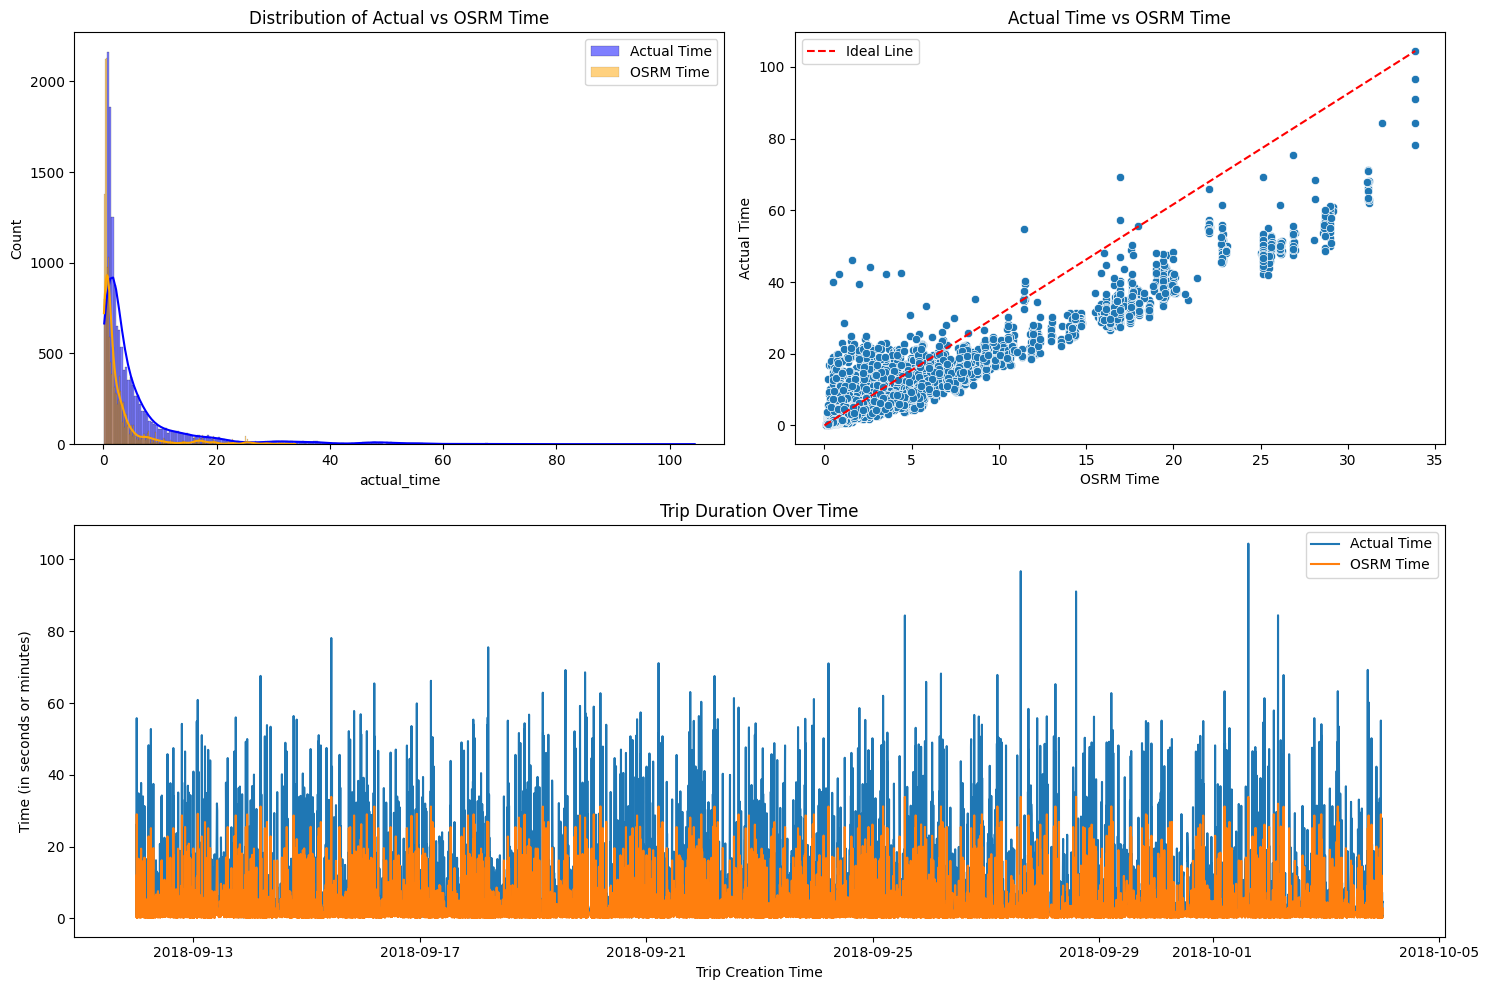

In [227]:
plt.figure(figsize=(15, 10))

# Subplot 1: Histogram
plt.subplot(2, 2, 1)
sns.histplot(trip['actual_time'], kde=True, color='blue', label='Actual Time')
sns.histplot(trip['osrm_time'], kde=True, color='orange', label='OSRM Time')
plt.title("Distribution of Actual vs OSRM Time")
plt.legend()

# Subplot 2: Scatter plot
plt.subplot(2, 2, 2)
sns.scatterplot(data=trip, x='osrm_time', y='actual_time')
plt.plot([0, trip['osrm_time'].max()], [0, trip['actual_time'].max()], 'r--', label='Ideal Line')
plt.xlabel("OSRM Time")
plt.ylabel("Actual Time")
plt.title("Actual Time vs OSRM Time")
plt.legend()

# Subplot 3: Line plot
plt.subplot(2, 1, 2)  # spans the full width in the second row
trip_sorted = trip.sort_values(by='trip_creation_time')
plt.plot(trip_sorted['trip_creation_time'], trip_sorted['actual_time'], label='Actual Time')
plt.plot(trip_sorted['trip_creation_time'], trip_sorted['osrm_time'], label='OSRM Time')
plt.legend()
plt.title("Trip Duration Over Time")
plt.xlabel("Trip Creation Time")
plt.ylabel("Time (in seconds or minutes)")

# Adjust layout
plt.tight_layout()
plt.show()



**Comparision of Actual distance to OSRM distance**

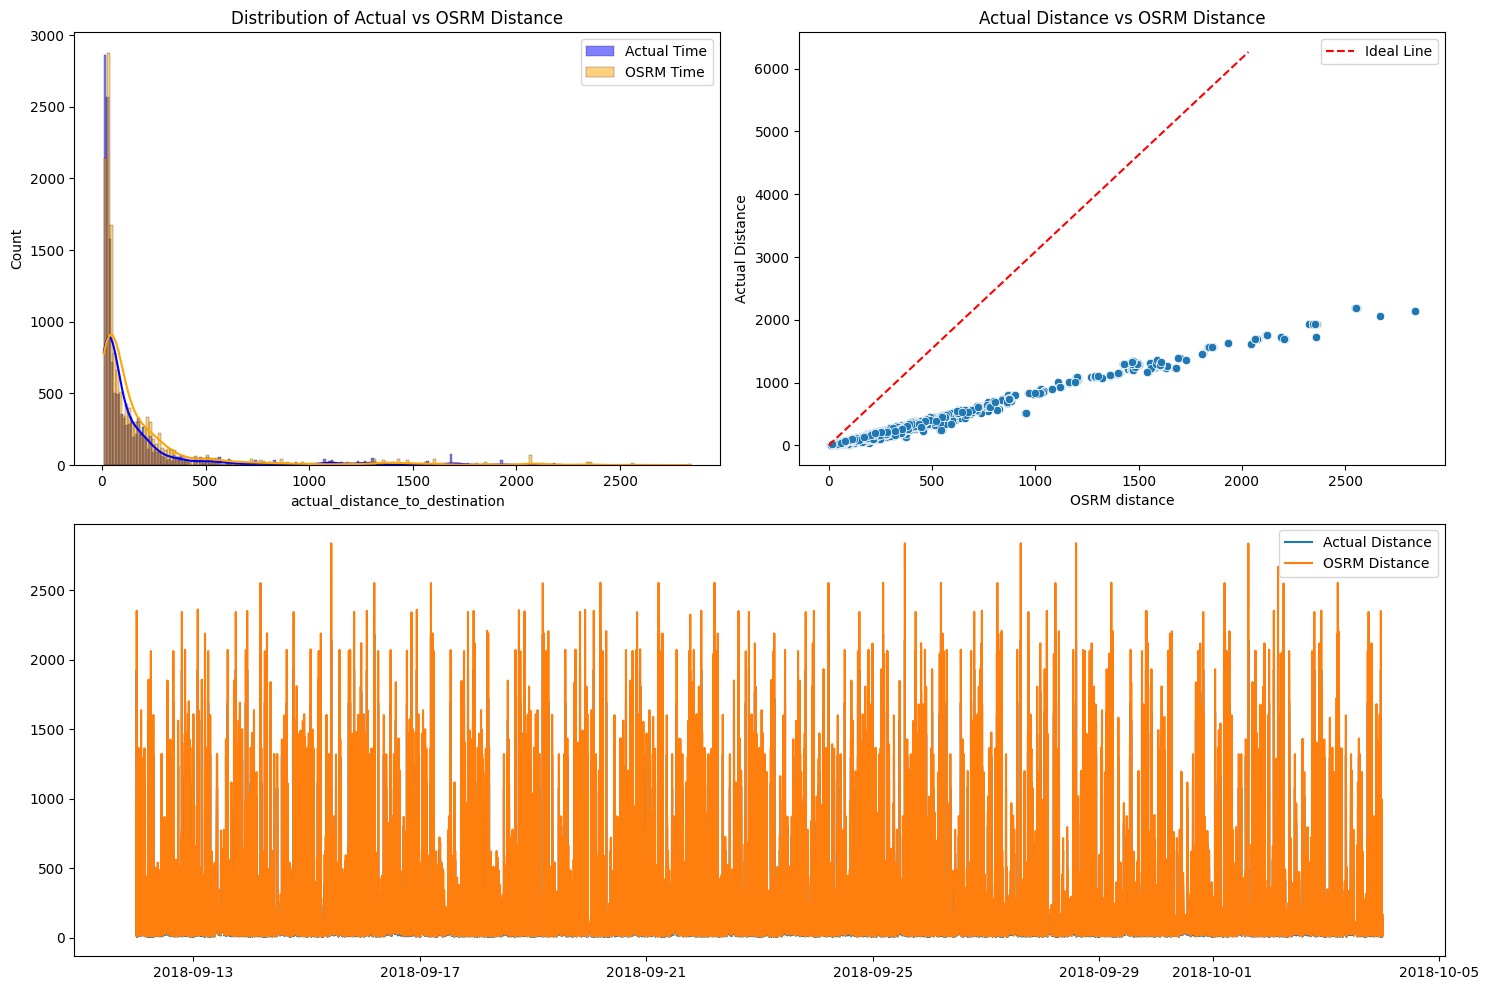

In [160]:
plt.figure(figsize=(15, 10))

# Subplot 1: Histogram
plt.subplot(2, 2, 1)
sns.histplot(trip['actual_distance_to_destination'], kde=True, color='blue', label='Actual Time')
sns.histplot(trip['osrm_distance'], kde=True, color='orange', label='OSRM Time')
plt.title("Distribution of Actual vs OSRM Distance")
plt.legend()

# Subplot 2: Scatter plot
plt.subplot(2, 2, 2)
sns.scatterplot(data=trip, x='osrm_distance', y='actual_distance_to_destination')
plt.plot([0, trip['osrm_time'].max()], [0, trip['actual_time'].max()], 'r--', label='Ideal Line')
plt.xlabel("OSRM distance")
plt.ylabel("Actual Distance")
plt.title("Actual Distance vs OSRM Distance")
plt.legend()

# Subplot 3: Line plot
plt.subplot(2, 1, 2)  # spans the full width in the second row
trip_sorted = trip.sort_values(by='trip_creation_time')
plt.plot(trip_sorted['trip_creation_time'], trip_sorted['actual_distance_to_destination'], label='Actual Distance')
plt.plot(trip_sorted['trip_creation_time'], trip_sorted['osrm_distance'], label='OSRM Distance')
plt.legend()


# Adjust layout
plt.tight_layout()
plt.show()



**Visualization of columns with outliers**

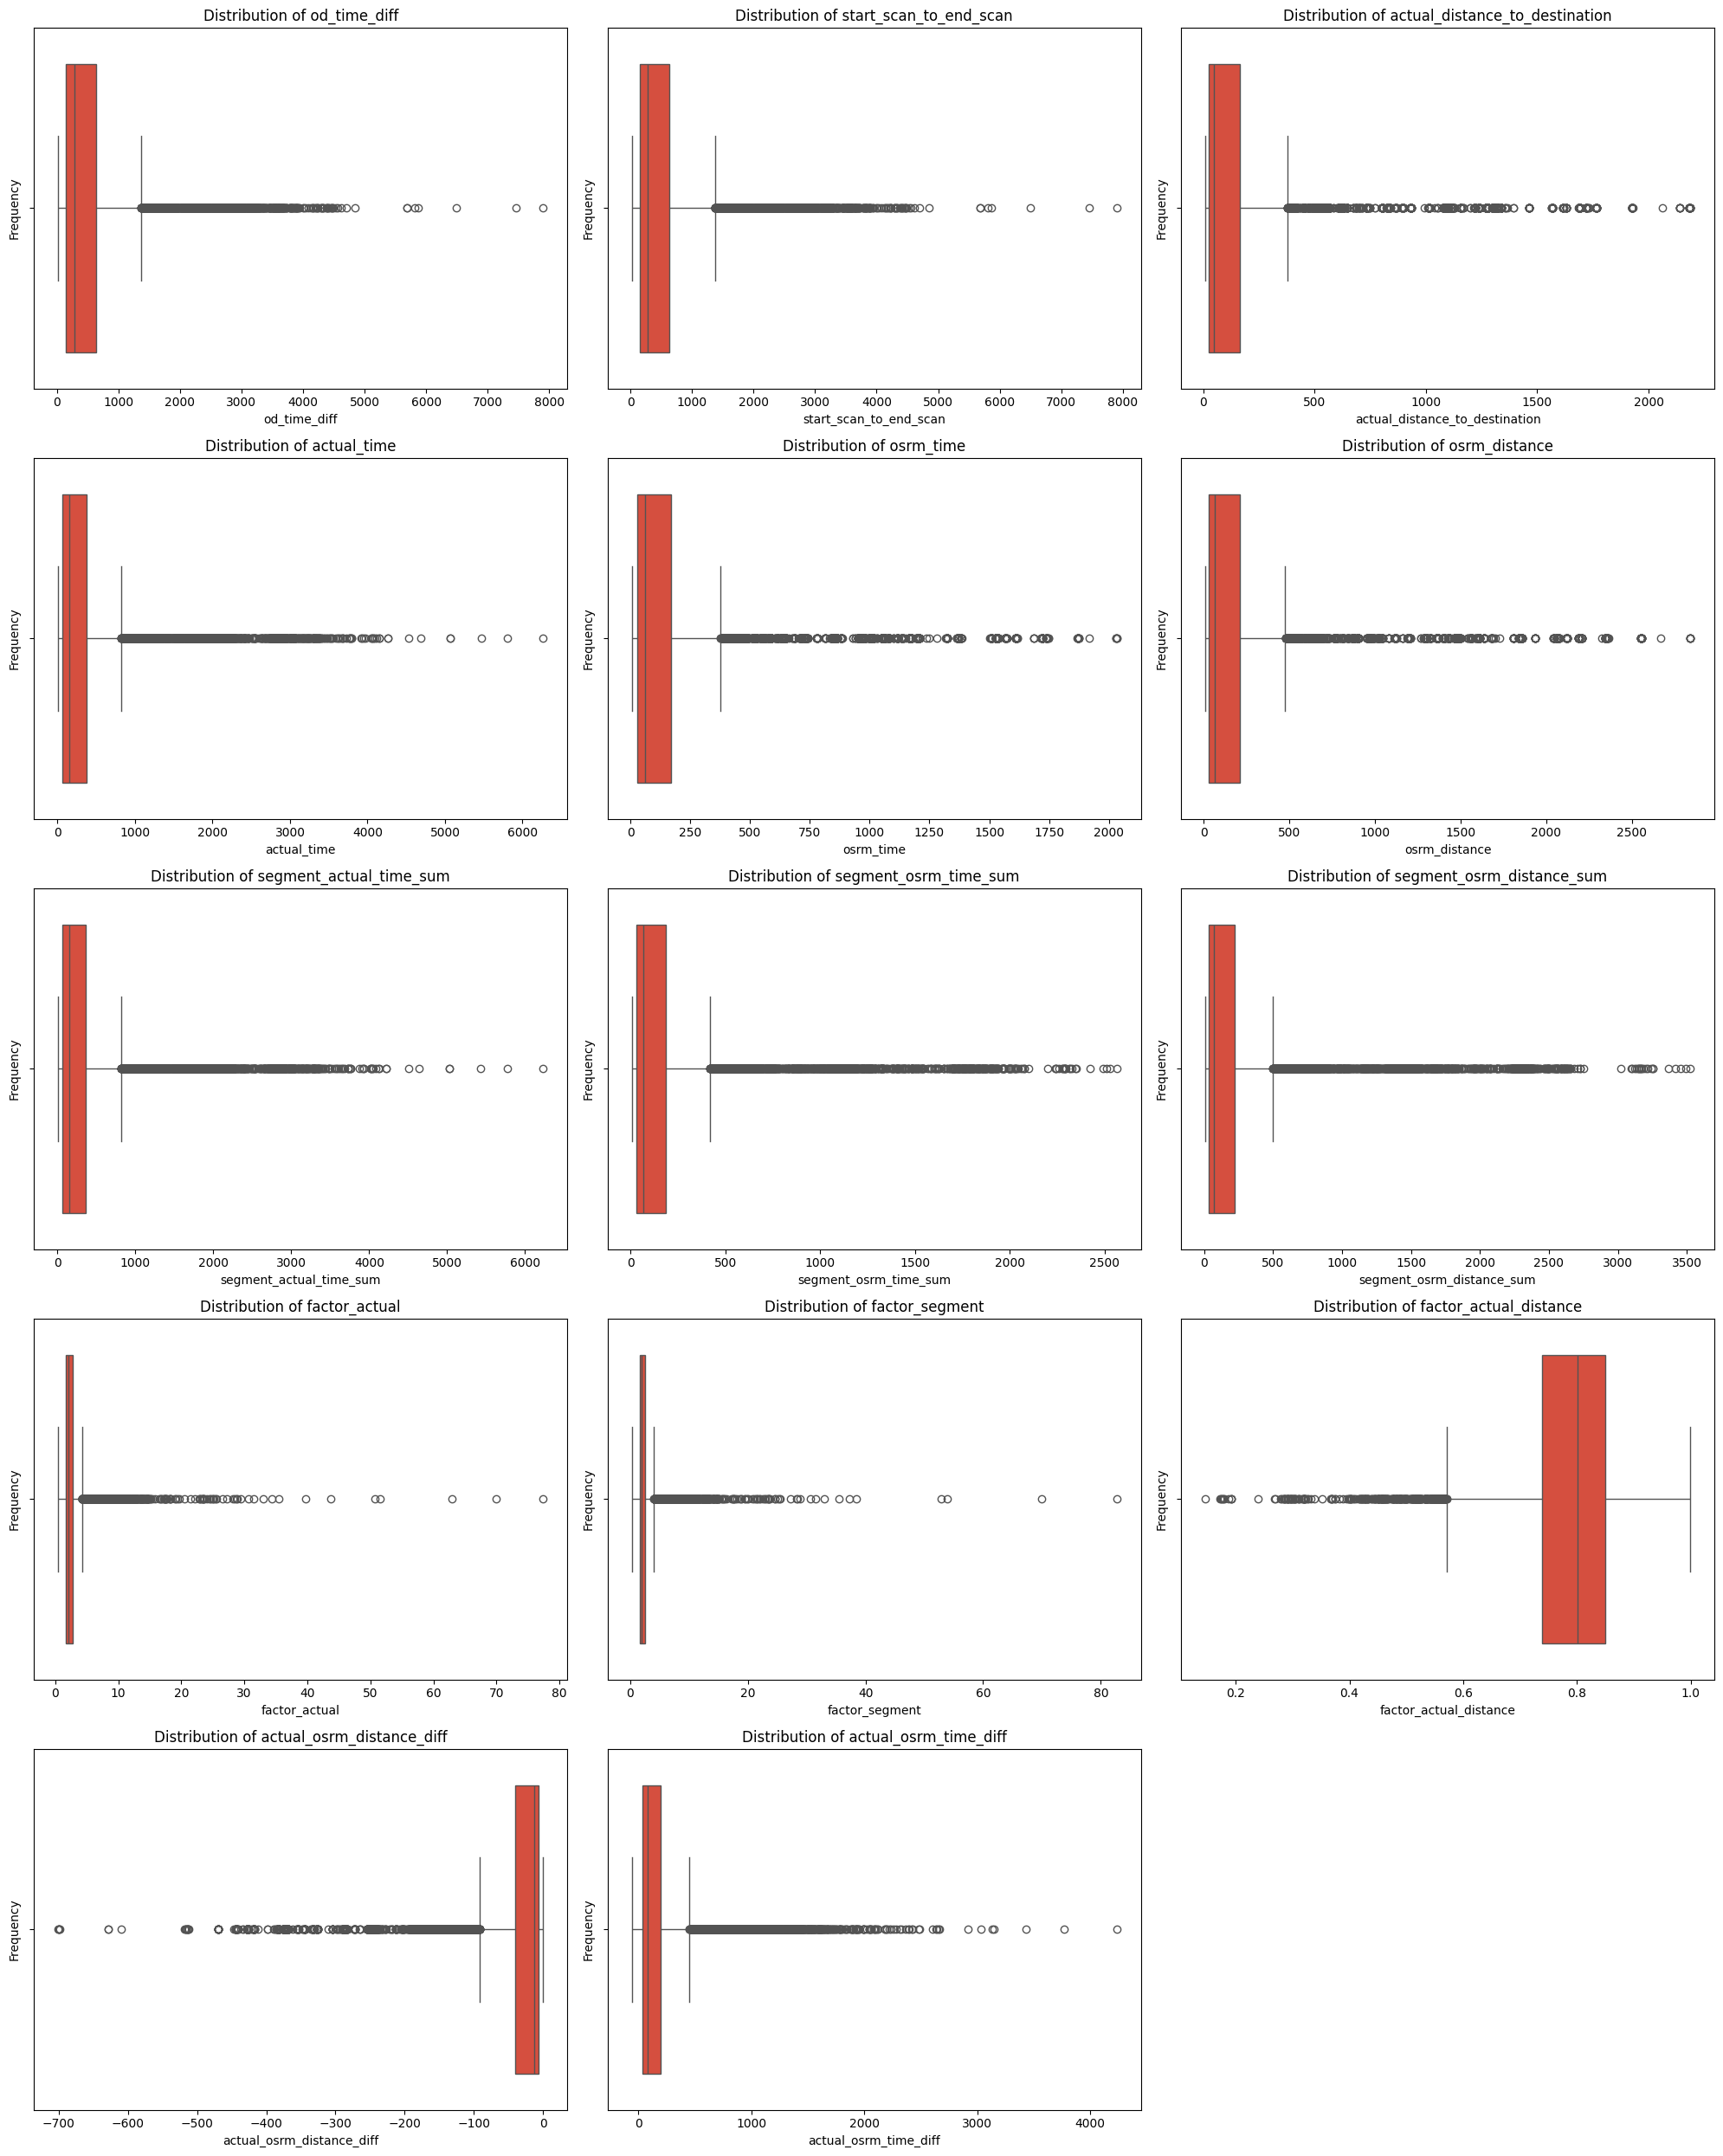

In [193]:
num_col= []
for i in list(trip.columns):
  if trip[i].dtype == 'float64':
    num_col.append(i)
n= len(num_col)

cols = 3 if n>2 else 1
rows = math.ceil(n/cols)

fig, axes = plt.subplots(rows, cols, figsize=(20,5 * rows))
axes = axes.flatten() if n > 1 else [axes]

for i, col in enumerate(num_col):
    sns.boxplot(data=trip,x= trip[col],ax=axes[i],color='#EE3C26')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

$$ Outlier \ treatment \ using \ IQR \ method $$

**Actual time Vs OSRM time**<br>
(factor = actual time/osrm time)

In [27]:
q1= np.percentile(trip['factor_actual'],25)
q3= np.percentile(trip['factor_actual'],75)
iqr= q3-q1


In [28]:
lower_bound= q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr
print(f"lower_bound for actual time is {lower_bound}")
print(f"upper_bound for actual time is {upper_bound}")

lower_bound for actual time is 0.2265625
upper_bound for actual time is 4.2890625


<Axes: xlabel='factor_actual', ylabel='Count'>

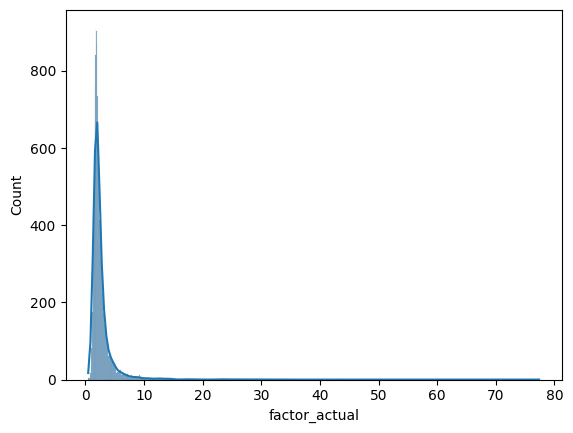

In [29]:
sns.histplot(data= trip, x= 'factor_actual',kde= True)

In [30]:
trip['is_outlier_actual_time']= (trip['factor_actual']> upper_bound)

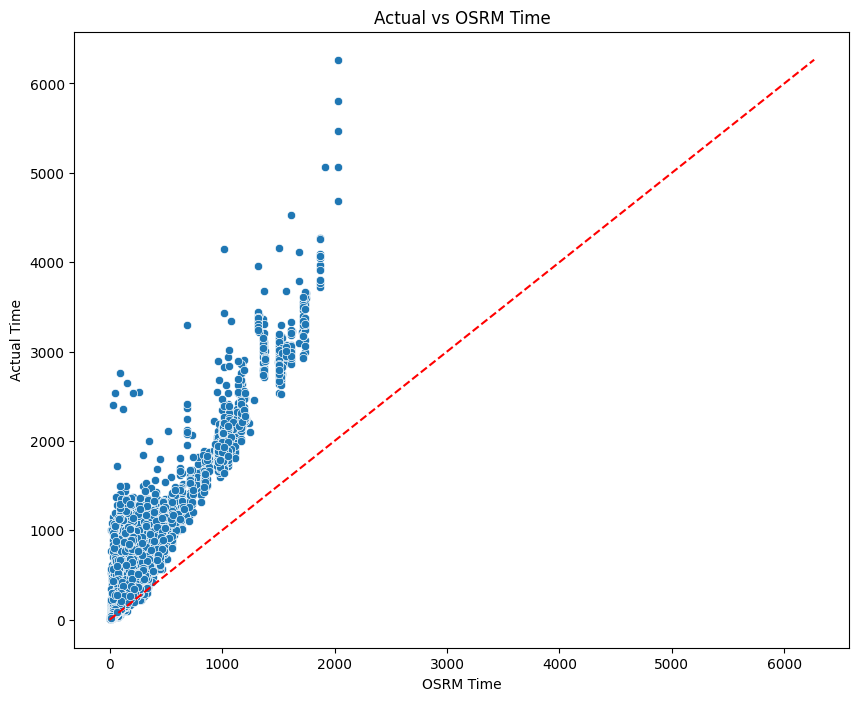

In [31]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=trip, x='osrm_time', y='actual_time')
max_value = max(trip['osrm_time'].max(), trip['actual_time'].max())
plt.plot([0,max_value],[0,max_value],'r--')
plt.xlabel("OSRM Time")
plt.ylabel("Actual Time")
plt.title("Actual vs OSRM Time")
plt.show()


**Actual Distance vs OSRM distance**<br>
(factor_actual_distance= actual distance to destination/osrm distance)

In [32]:
q1= np.percentile(trip['factor_actual_distance'],25)
q3 = np.percentile(trip['factor_actual_distance'],75)
iqr= q3-q1
lower_bound= q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr
print(f"lower_bound for actual time is {lower_bound}")
print(f"upper_bound for actual time is {upper_bound}")

lower_bound for actual time is 0.5706423809807708
upper_bound for actual time is 1.0170816566899155


In [33]:
trip['is_outlier_actual_distance']= (trip['factor_actual_distance']> upper_bound)

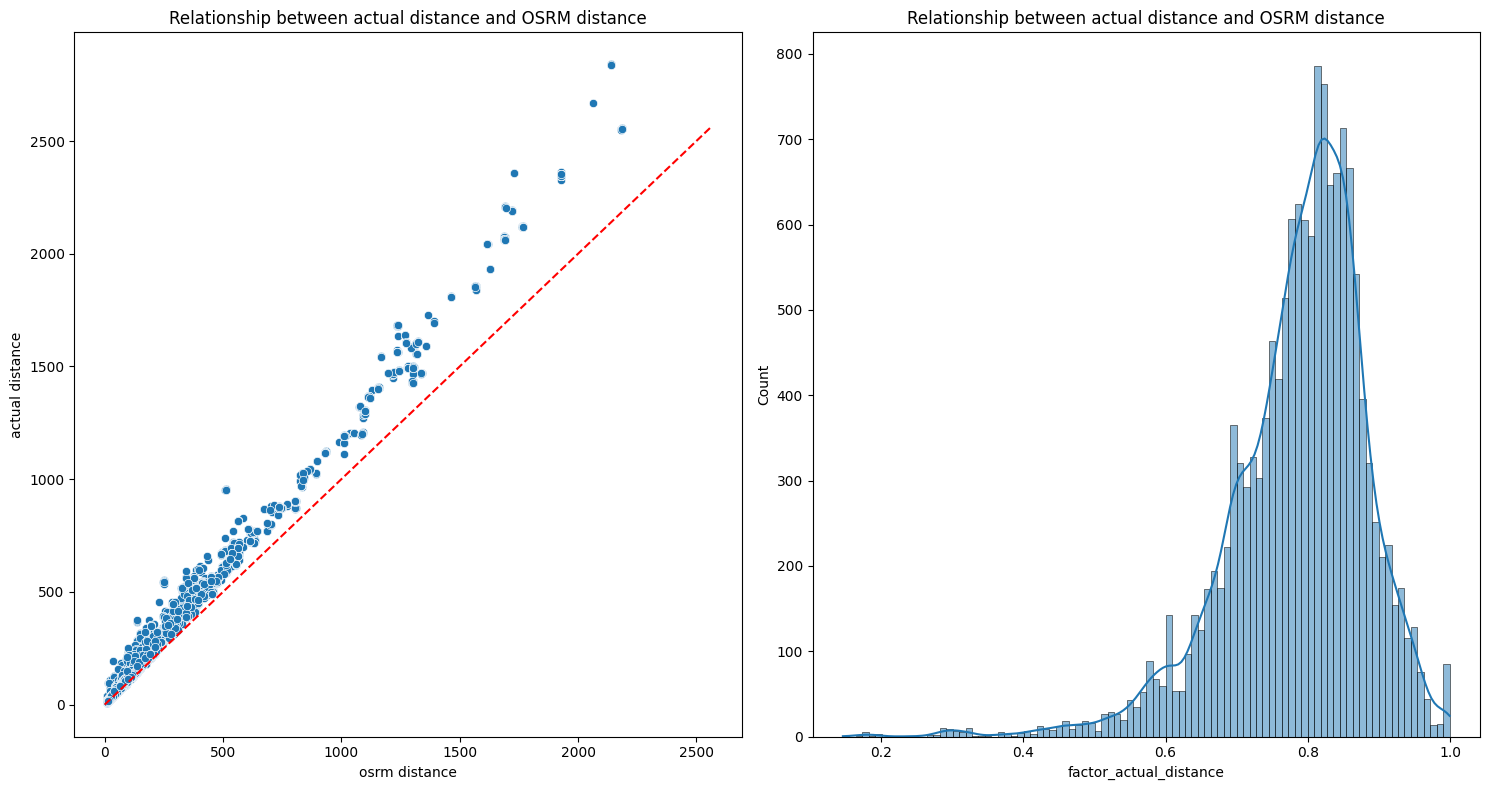

In [34]:
plt.figure(figsize = (15,8))
plt.subplot(1,2,1)
sns.scatterplot(data= trip,x='actual_distance_to_destination',y='osrm_distance')
plt.plot([0,trip['segment_osrm_time_sum'].max()],[0,trip['segment_osrm_time_sum'].max()],'r--')
plt.ylabel('actual distance')
plt.xlabel('osrm distance')
plt.title('Relationship between actual distance and OSRM distance')

plt.subplot(1,2,2)
sns.histplot(x= 'factor_actual_distance',data= trip,kde= True)
plt.title('Relationship between actual distance and OSRM distance')

plt.tight_layout()
plt.show()

**Segment Actual Time vs Segment OSRM Time**<br>
(factor_segment= segment_actual_time/segment_osrm_time)

In [35]:
q1_segment = np.percentile(trip['factor_segment'],25)
q3_segment = np.percentile(trip['factor_segment'],75)
iqr_segment = q3_segment-q1_segment

In [36]:
lower_bound_segment = q1-1.5*iqr_segment
upper_bound_segment = q3+1.5*iqr_segment

In [37]:
trip['is_outlier_segment_time'] =  (trip['factor_segment']>upper_bound_segment)

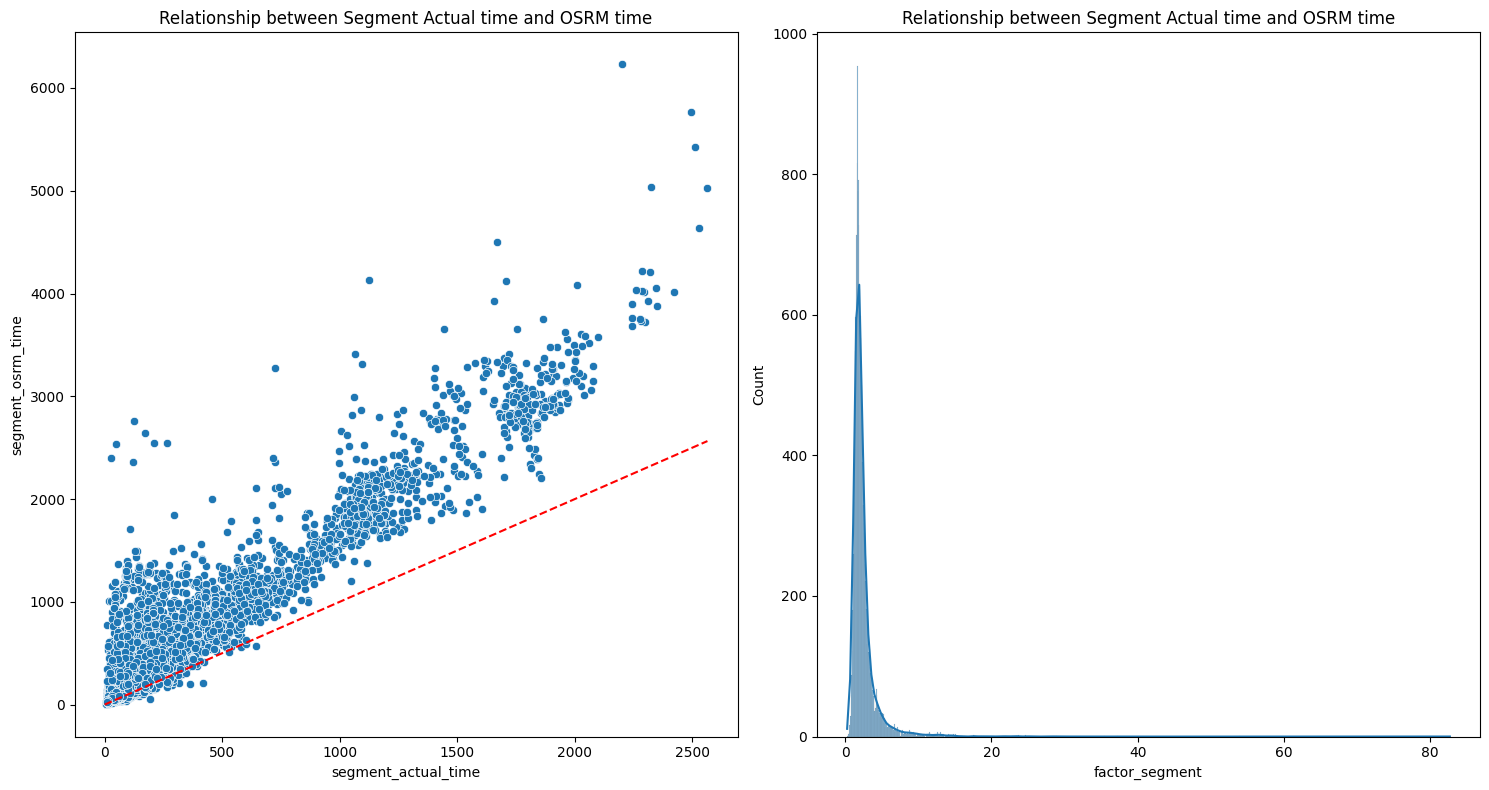

In [38]:
plt.figure(figsize = (15,8))
plt.subplot(1,2,1)
sns.scatterplot(data= trip,x='segment_osrm_time_sum',y='segment_actual_time_sum')
plt.plot([0,trip['segment_osrm_time_sum'].max()],[0,trip['segment_osrm_time_sum'].max()],'r--')
plt.ylabel('segment_osrm_time')
plt.xlabel('segment_actual_time')
plt.title('Relationship between Segment Actual time and OSRM time')

plt.subplot(1,2,2)
sns.histplot(data= trip, x='factor_segment',kde= True)
plt.title('Relationship between Segment Actual time and OSRM time')
plt.tight_layout()
plt.show()

**Outlier Treatment**

1. In my opnion factor is a better measure to check for outliers in time taken to complete a trip.
2. Factor calculation is **actual_time/osrm_time**
3. The outliers represent rare but valid scenarios, e.g., unusually long   deliveries due to strikes, weather, or breakdowns.
4. The outliers help explain delays, inefficiencies, or risk in your system (which is often the case in transport/logistics datasets).
5. Instead of dropping the rows with outliers I am flagging those transactions outliers as a new column so that the model can learn from this feature too.
6. Using outliers in our data we can find poor performing routes and other operational ineffencies



<h3>$$Hypothesis \ Testing \ to \ find \ if \ the \ difference \ between \ the\  features \ are \ statisticaly \ significant \ or \ not.$$ </h3>

**OD time difference Vs Start scan to End scan**

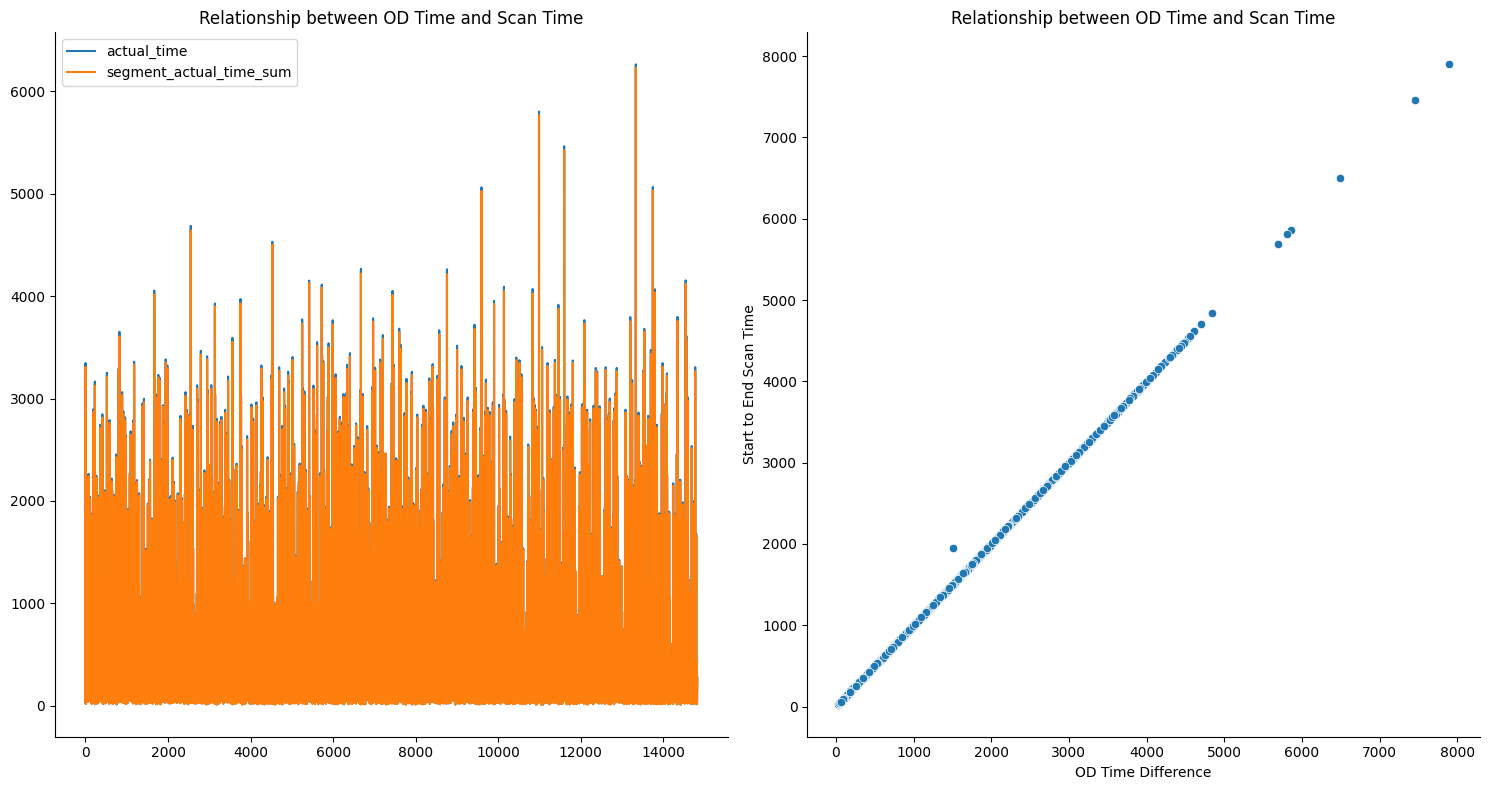

In [44]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
trip['actual_time'].plot(kind='line')
trip['segment_actual_time_sum'].plot(kind='line')
plt.title("Relationship between OD Time and Scan Time")
plt.legend()

plt.subplot(1,2,2)
sns.scatterplot(data= trip, x='od_time_diff', y='start_scan_to_end_scan')
plt.xlabel("OD Time Difference")
plt.ylabel("Start to End Scan Time")
plt.title("Relationship between OD Time and Scan Time")

sns.despine()
plt.tight_layout()
plt.show()


**Statistical test to check if the difference is significant or not**

ho: there is no significant difference between od_time_diff and start_scan_to_end_scan<br>
ha: there is a statistical difference between od_time_diff and start_scan_to_end_scan<br>

In [45]:
data = trip[['od_time_diff', 'start_scan_to_end_scan']].dropna()

# Paired t-test
t_stat, p_value = ttest_rel(data['od_time_diff'], data['start_scan_to_end_scan'])

print("Paired T-Test Results:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between actual time and OSRM time.")
else:
    print("Fail to reject the null hypothesis: No significant difference found.")


Paired T-Test Results:
T-statistic: 28.600714091950817
P-value: 3.6323324088155984e-175
Reject the null hypothesis: There is a significant difference between actual time and OSRM time.


In [46]:
test= trip[['od_time_diff', 'start_scan_to_end_scan']]
test['diff'] = test['od_time_diff']- test['start_scan_to_end_scan']

In [47]:
cohen_d = test['diff'].mean() / test['diff'].std()
print(f"Cohen's d: {cohen_d}")


Cohen's d: 0.23496151626087436


In our case hypothesis test shows there is a significant statiscital difference between the od_time_diff and start_scan_to_end_scan. But there is a difference between statistically significant and practical difference:
hence i have also calculated Cohen's D number to check the practical difference the two measures.Here are the results:
1. alpha--- 0.05
2. p-value --- 3.632e-175
3. cohen's d--- 0.234

therefor we can say even if the paired t-test shows a statistically significant difference but according to choen's d number we can say they are not that different.

**Actual Time vs OSRM Time**

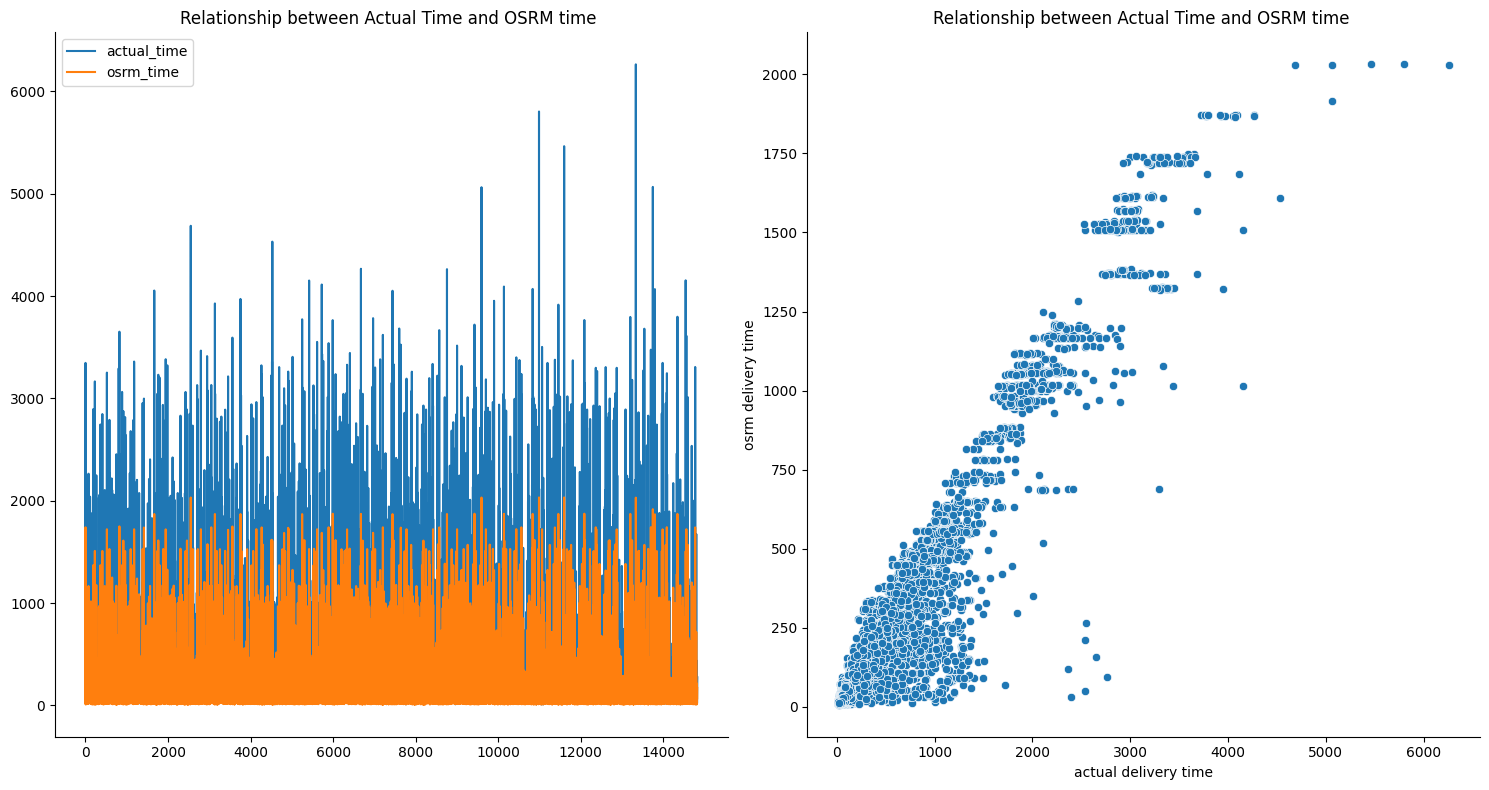

In [48]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
trip['actual_time'].plot(kind='line')
trip['osrm_time'].plot(kind='line')
plt.title('Relationship between Actual Time and OSRM time ')
plt.legend()

plt.subplot(1,2,2)
sns.scatterplot(data= trip, x='actual_time',y='osrm_time')
plt.xlabel('actual delivery time')
plt.ylabel('osrm delivery time')
plt.title('Relationship between Actual Time and OSRM time ')
sns.despine()
plt.tight_layout()
plt.show()

**Statistical test to check if the difference between the two are statistically significant or not.**  <br>

ho: there is no statistical difference between the two<br>
ha: there is a statistical difference between the two

In [49]:
data = trip[['actual_time', 'osrm_time']].dropna()

# Paired t-test
t_stat, p_value = ttest_rel(data['actual_time'], data['osrm_time'])

print("Paired T-Test Results:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between actual time and OSRM time.")
else:
    print("Fail to reject the null hypothesis: No significant difference found.")


Paired T-Test Results:
T-statistic: 76.61411942262393
P-value: 0.0
Reject the null hypothesis: There is a significant difference between actual time and OSRM time.


In [50]:
test= trip[['actual_time','osrm_time']]
test['diff'] = test['actual_time']- test['osrm_time']


In [51]:
cohen_d = test['diff'].mean()/test['diff'].std()
print(f"Cohen's d: {cohen_d}")

Cohen's d: 0.6294028047221925


The test shows there is a significant difference between the actual time and osrm time , which is also visual thorugh our plots. Cohen's D number also tell that there is a meaningful difference between the two features.

1. alpha-- 0.05
2. p-value-- 0.0
3. cohen's d -- 0.629



**Actual time and Segment actual time**

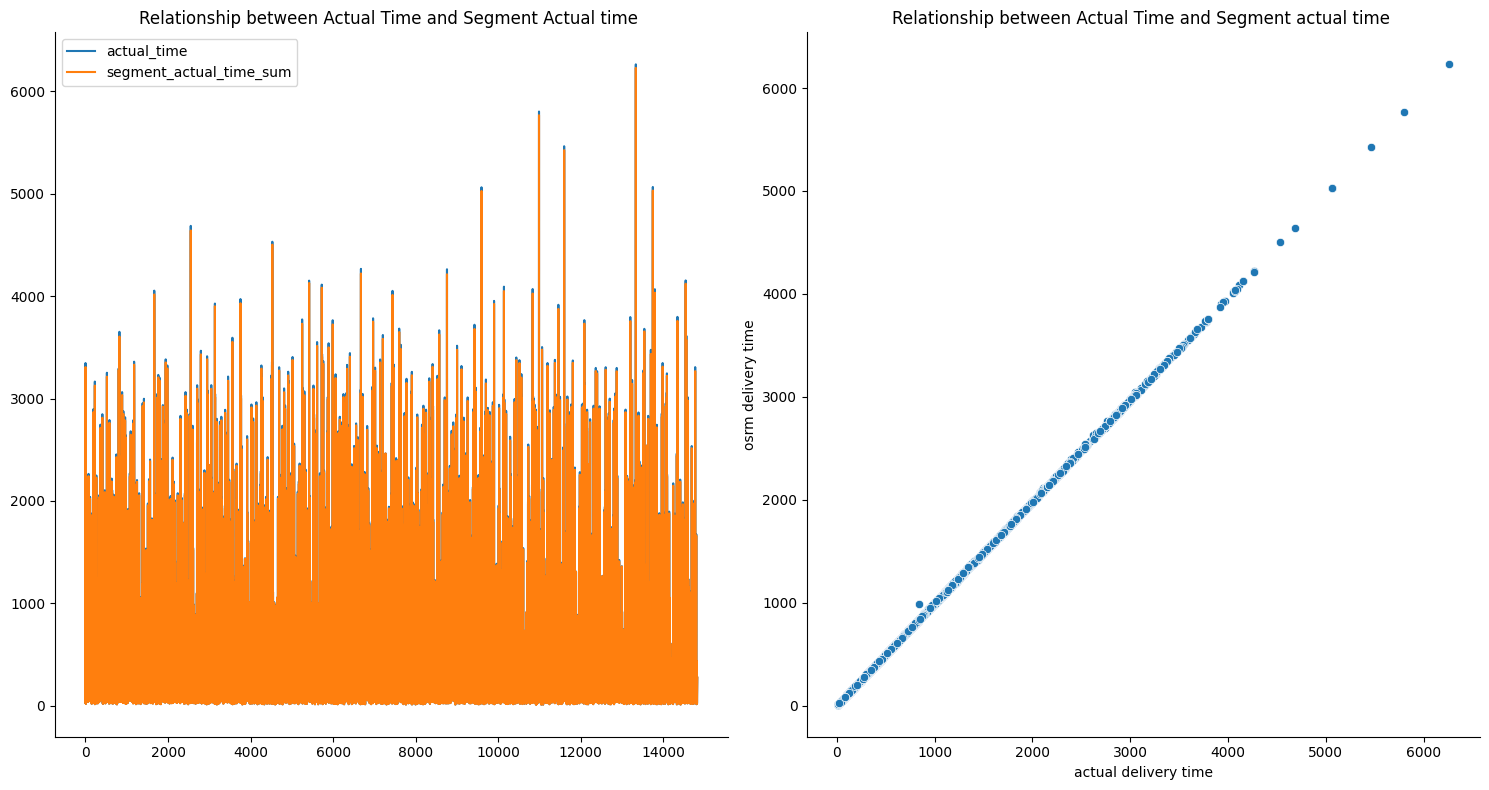

In [52]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
trip['actual_time'].plot(kind='line')
trip['segment_actual_time_sum'].plot(kind='line')
plt.title('Relationship between Actual Time and Segment Actual time ')
plt.legend()

plt.subplot(1,2,2)
sns.scatterplot(data= trip, x='actual_time',y='segment_actual_time_sum')
plt.xlabel('actual delivery time')
plt.ylabel('osrm delivery time')
plt.title('Relationship between Actual Time and Segment actual time ')
sns.despine()
plt.tight_layout()
plt.show()

**Statistical test to check if the difference between the two are statistically significant or not.**  <br>

ho: there is no statistical difference between the two<br>
ha: there is a statistical difference between the two

In [53]:
data = trip[['actual_time', 'segment_actual_time_sum']].dropna()

# Paired t-test
t_stat, p_value = ttest_rel(data['actual_time'], data['segment_actual_time_sum'])

print("Paired T-Test Results:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between actual time and OSRM time.")
else:
    print("Fail to reject the null hypothesis: No significant difference found.")


Paired T-Test Results:
T-statistic: 68.46429609754104
P-value: 0.0
Reject the null hypothesis: There is a significant difference between actual time and OSRM time.


In [54]:
test= trip[['actual_time','segment_actual_time_sum']]
test['diff'] = test['actual_time']- test['segment_actual_time_sum']

In [55]:
cohen_d = test['diff'].mean()/test['diff'].std()
print(f"Cohen's d: {cohen_d}")

Cohen's d: 0.5624501111788207


In our case hypothesis test shows there is a significant statiscital difference between the actual_time and segment_actual_time. But there is a difference between statistically significant and practical difference:
hence i have also calculated Cohen's D number to check the practical difference the two measures.Here are the results:
1. alpha--- 0.05
2. p-value --- 3.632e-175
3. cohen's d--- 0.562<br>
Cohen's D value greater than 0.5 tells we have a moderate but meaningful difference between the two features.

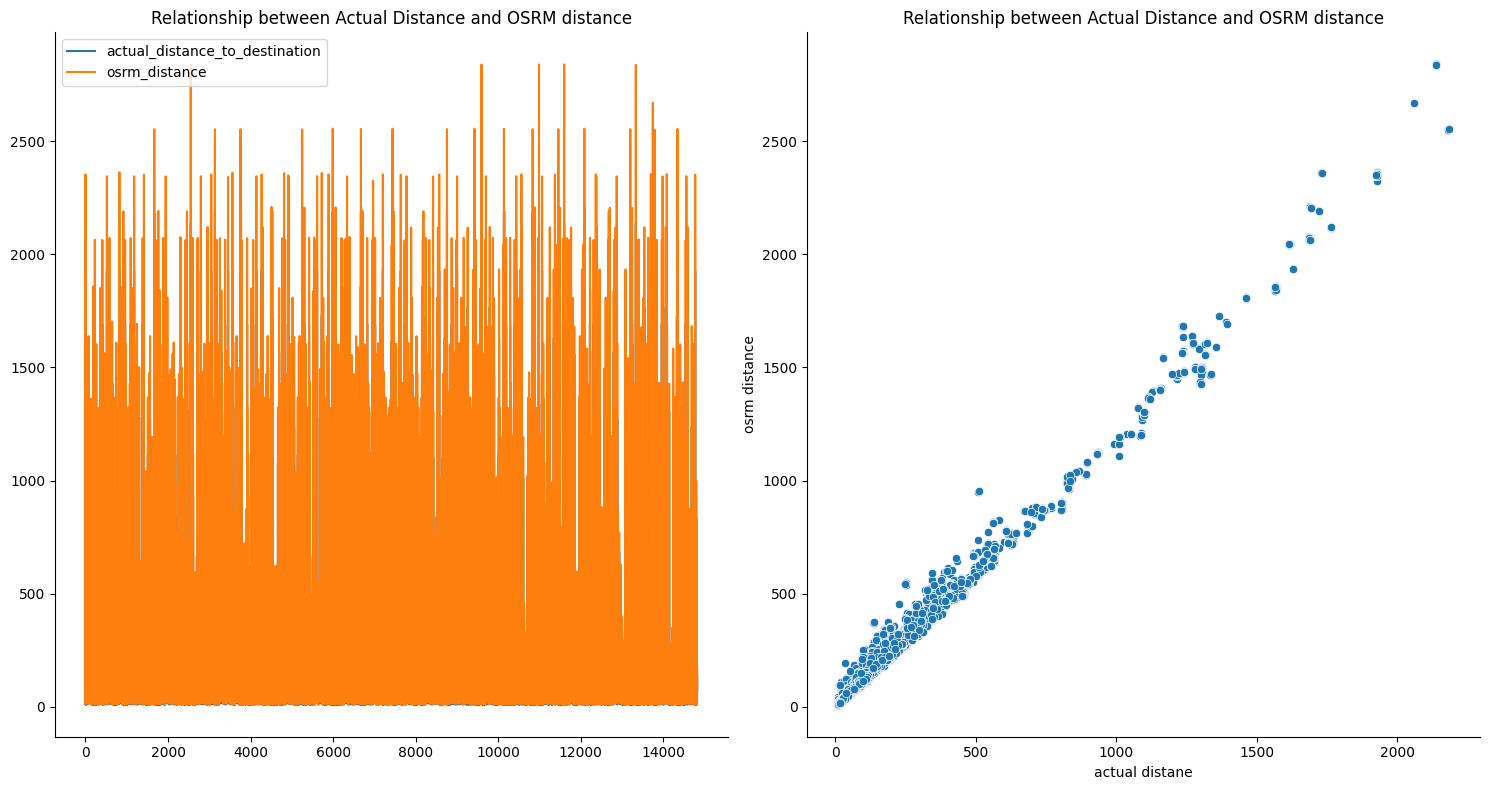

In [57]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
trip['actual_distance_to_destination'].plot(kind='line')
trip['osrm_distance'].plot(kind='line')
plt.title('Relationship between Actual Distance and OSRM distance')
plt.legend()

plt.subplot(1,2,2)
sns.scatterplot(data= trip, x='actual_distance_to_destination',y='osrm_distance')
plt.xlabel('actual distane')
plt.ylabel('osrm distance')
plt.title('Relationship between Actual Distance and OSRM distance')
sns.despine()
plt.tight_layout()
plt.show()

**Actual Distance VS OSRM distance**

**Statistical test to check if the difference between the two are statistically significant or not.**  <br>

ho: there is no statistical difference between the two<br>
ha: there is a statistical difference between the two

In [58]:
data = trip[['actual_distance_to_destination', 'osrm_distance']].dropna()

# Paired t-test
t_stat, p_value = ttest_rel(data['actual_distance_to_destination'], data['osrm_distance'])

print("Paired T-Test Results:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between actual time and OSRM time.")
else:
    print("Fail to reject the null hypothesis: No significant difference found.")


Paired T-Test Results:
T-statistic: -69.71933755485986
P-value: 0.0
Reject the null hypothesis: There is a significant difference between actual time and OSRM time.


In [59]:
test_1= trip[['actual_distance_to_destination','osrm_distance']]
test_1['diff'] = test_1['actual_distance_to_destination']- test_1['osrm_distance']

In [60]:
cohens_d = test_1['diff'].mean()/test_1['diff'].std()
print(f'cohens d value {cohens_d}')

cohens d value -0.5727605685623034


In our case hypothesis test shows there is a significant statiscital difference between the actual_time and segment_actual_time. But there is a difference between statistically significant and practical difference:
hence i have also calculated Cohen's D number to check the practical difference the two measures.Here are the results:
1. alpha--- 0.05
2. p-value --- 0.0
3. cohen's d--- 0.5727<br>
Cohen's D value greater than 0.5 tells we have a moderate but meaningful difference between the two features. ignored the negative sign.

**OSRM time and Segment OSRM time**

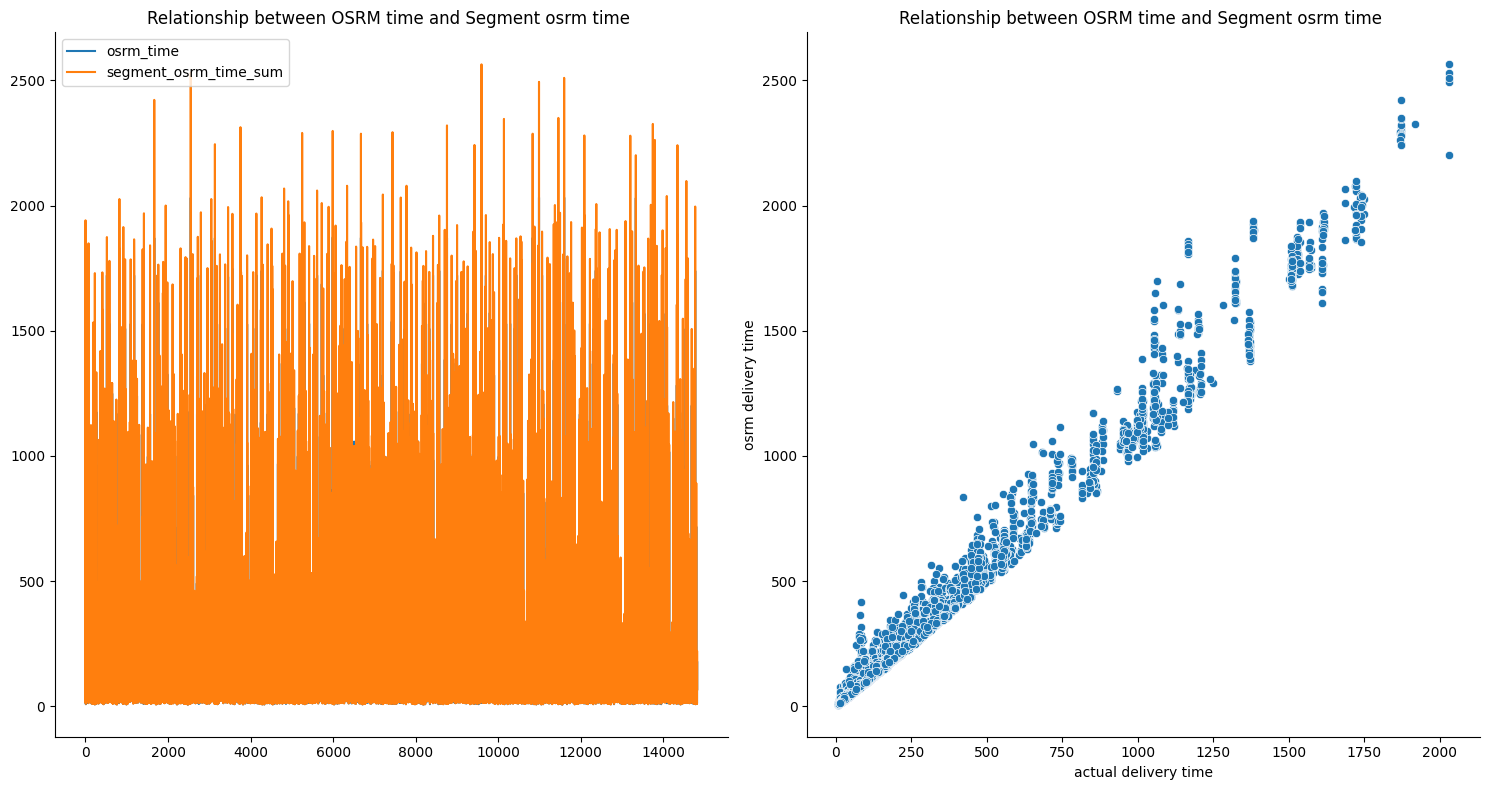

In [61]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
trip['osrm_time'].plot(kind='line')
trip['segment_osrm_time_sum'].plot(kind='line')
plt.title('Relationship between OSRM time and Segment osrm time ')
plt.legend()

plt.subplot(1,2,2)
sns.scatterplot(data= trip, x='osrm_time',y='segment_osrm_time_sum')
plt.xlabel('actual delivery time')
plt.ylabel('osrm delivery time')
plt.title('Relationship between OSRM time and Segment osrm time ')
sns.despine()
plt.tight_layout()
plt.show()

In [62]:
data = trip[['osrm_time', 'segment_osrm_time_sum']].dropna()

# Paired t-test
t_stat, p_value = ttest_rel(data['osrm_time'], data['segment_osrm_time_sum'])

print("Paired T-Test Results:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between actual time and OSRM time.")
else:
    print("Fail to reject the null hypothesis: No significant difference found.")


Paired T-Test Results:
T-statistic: -43.37186612146427
P-value: 0.0
Reject the null hypothesis: There is a significant difference between actual time and OSRM time.


In [63]:
test_1= trip[['osrm_time','segment_osrm_time_sum']]
test_1['diff'] = test_1['osrm_time']- test_1['segment_osrm_time_sum']

In [64]:
cohens_d = test_1['diff'].mean()/test_1['diff'].std()
print(f'cohens d value {cohens_d}')

cohens d value -0.35630996464633174


In our case hypothesis test shows there is a significant statiscital difference between the actual_time and segment_actual_time. But there is a difference between statistically significant and practical difference:
hence i have also calculated Cohen's D number to check the practical difference the two measures.Here are the results:
1. alpha--- 0.05
2. p-value --- 0.0
3. cohen's d--- 0.3563<br>
Cohen's D value between 0.2 and 0.5 tells we have a small but noticeable difference between the two features. **Ignored the negative sign**.

**Encoding and Scaling Categorical and Numerical columns**

In [237]:
cat_cols = ['route_type', 'source_center', 'destination_center', 'state', 'city', 'depot']
trip_encoded = pd.get_dummies(trip, columns=cat_cols, drop_first=True)

num_cols = [
    'od_time_diff', 'start_scan_to_end_scan', 'actual_distance_to_destination',
    'actual_time', 'osrm_time', 'osrm_distance', 'segment_actual_time_sum',
    'segment_osrm_time_sum', 'segment_osrm_distance_sum', 'factor_actual',
    'factor_segment', 'factor_actual_distance', 'actual_osrm_distance_diff',
    'actual_osrm_time_diff'
]
scaler = StandardScaler()
trip_encoded[num_cols] = scaler.fit_transform(trip_encoded[num_cols])


**Business Insights:**

1. The data we have is of 2 months only September and October of year 2018.
2.Certain source-destination pairs consistently show high actual_osrm_time_diff (difference between actual and expected time).
3.There’s a visible and statistically significant gap between actual_time and osrm_time.
4.Outliers exist in actual_time, osrm_time, actual_distance, and osrm_distance, verified through IQR, z-scores, and boxplots.
5.Cleaned and grouped data can serve as performance dashboards.
6.Certain states and cities consistently show lower or higher delivery volumes and delays.
7.Missing values in source_name, destination_name, state, city, and depot could impact modeling.
8.Routes differ in performance and volume based on route_type.
Most of the trips the company have 60% are carting trips and only 40% are FTL trips.



**Recommendation:**
1. Re-evaluation and optimization of the top 10 most delayed routes.
2. Improve ETA accuracy shown to customers and operations teams.
3.Review operational logs of extreme outlier trips to understand disruptions (e.g., road closures, weather, vehicle issues).
4.Track perforamance metrics like Average delay,top performing routes and delay ratios.
5. Explore why some states like TR, MZ, NL have fewer deliveries—infra issues, lower demand, or market gaps.
6. Automate imputation or flagging for incomplete entries,enforce data validation at ingestion points.
7. Company should focus more on getting FTL as it can help in capacity optimization.
8. Treat FTL and Carting routes separately in performance benchmarks and forecasting.
